In [1]:
from collections import defaultdict
from itertools import product
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import seaborn as sns
import sklearn.metrics as skm
import sklearn.utils as skut
import sklearn.preprocessing as skpp
import time
import warnings

from tabpfn import TabPFNClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
import condo

In [2]:
datapath = "/Users/calvinm/sandbox/JointMDS/datasets/SNARE"
Xs = np.load(f"{datapath}/scatac_feat.npy")
Xt = np.load(f"{datapath}/scrna_feat.npy")
Zs = np.loadtxt(f"{datapath}/SNAREseq_atac_types.txt").astype(int).astype(str).reshape(-1, 1)
Zt = np.loadtxt(f"{datapath}/SNAREseq_rna_types.txt").astype(int).astype(str).reshape(-1, 1)
celldict = {'1': 'H1', '2': 'GM', '3': 'BJ', '4': 'K562'}
Xsn = skpp.Normalizer().fit_transform(Xs)
Xtn = skpp.Normalizer().fit_transform(Xt)

# paired-sample info
Ys = np.arange(Xs.shape[0]).astype(str).reshape(-1, 1)
Yt = np.arange(Xt.shape[0]).astype(str).reshape(-1, 1)

transform_type = 'affine'

In [3]:
adapter = condo.AdapterMMD(transform_type=transform_type, verbose=0)
adapter.fit(Xsn, Xtn)
Xsn2tn_mmd = skpp.Normalizer().fit_transform(adapter.transform(Xsn))

adapter = condo.ConDoAdapterMMD(transform_type=transform_type, verbose=0)
adapter.fit(Xsn, Xtn, Zs, Zt)
Xsn2tn_cmmd = skpp.Normalizer().fit_transform(adapter.transform(Xsn))

/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalize

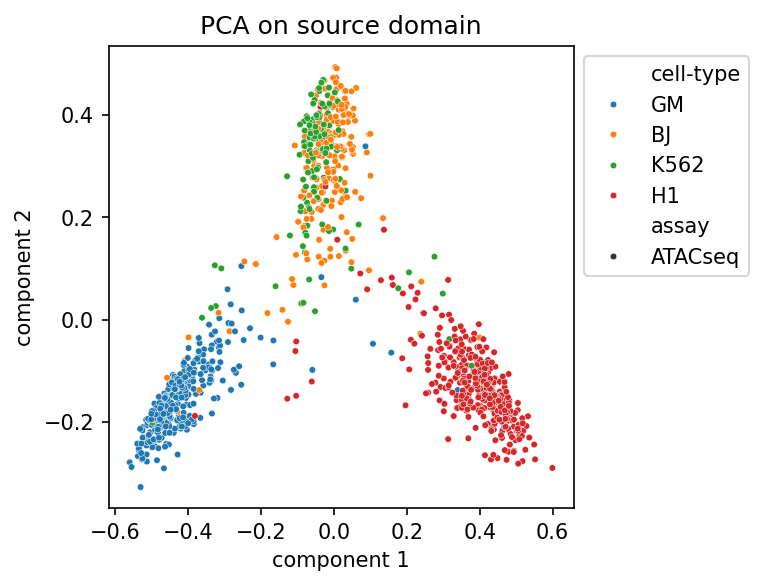

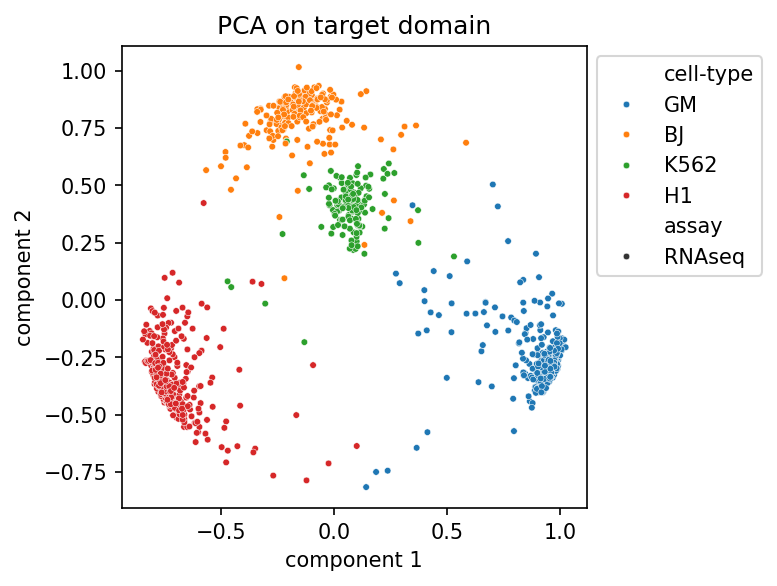

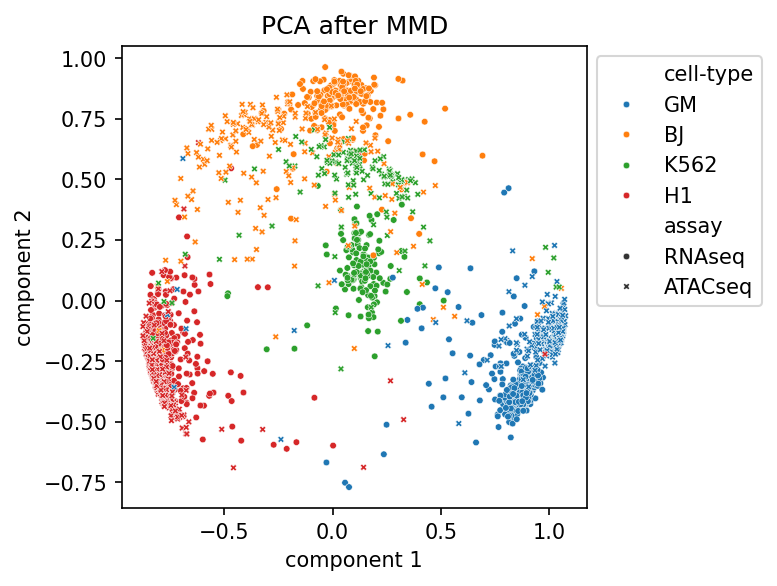

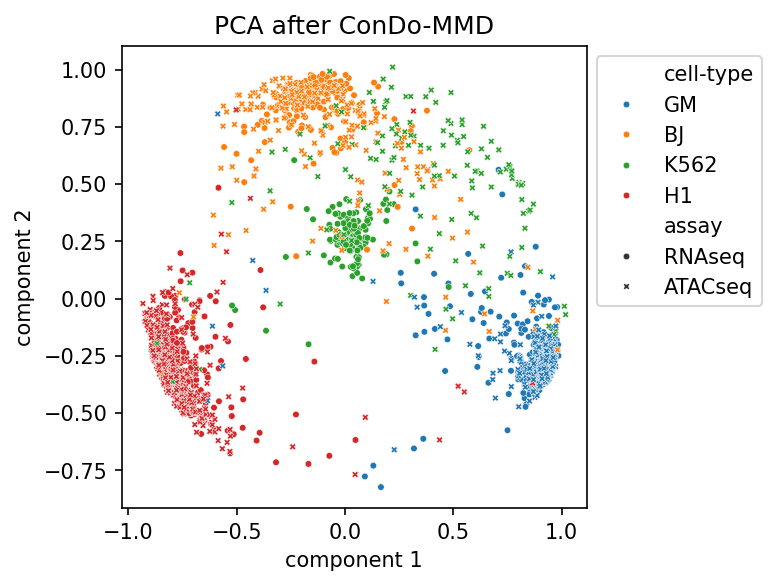

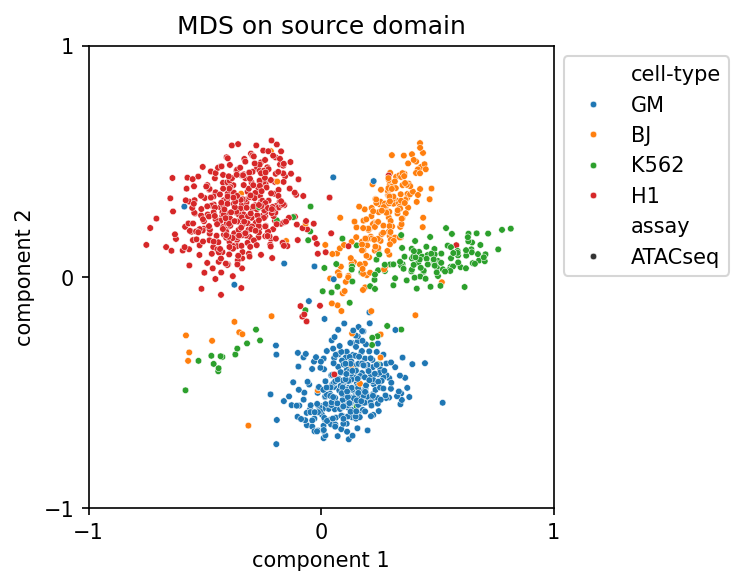

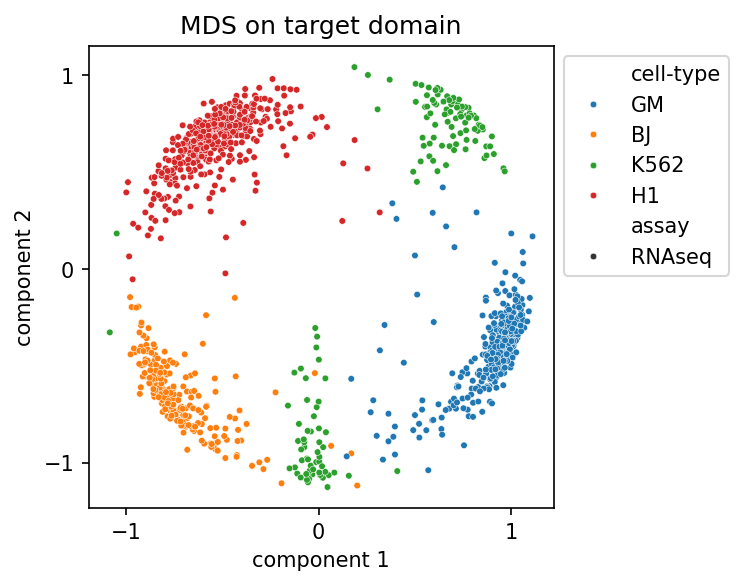

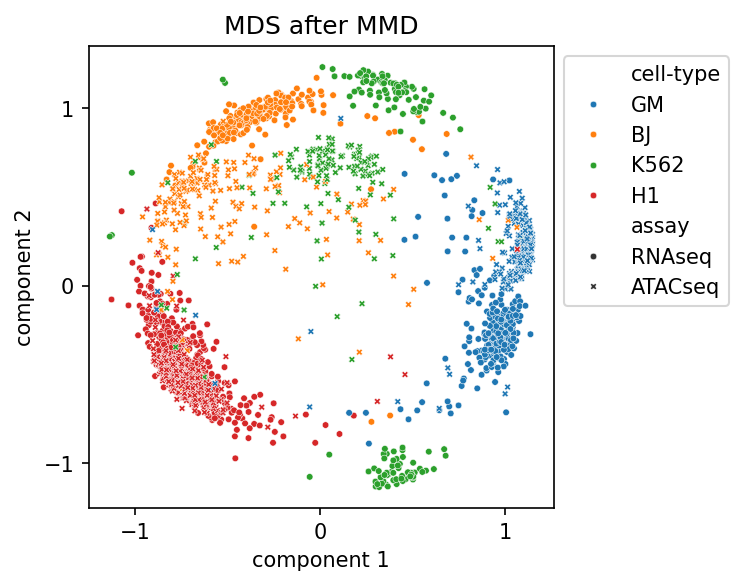

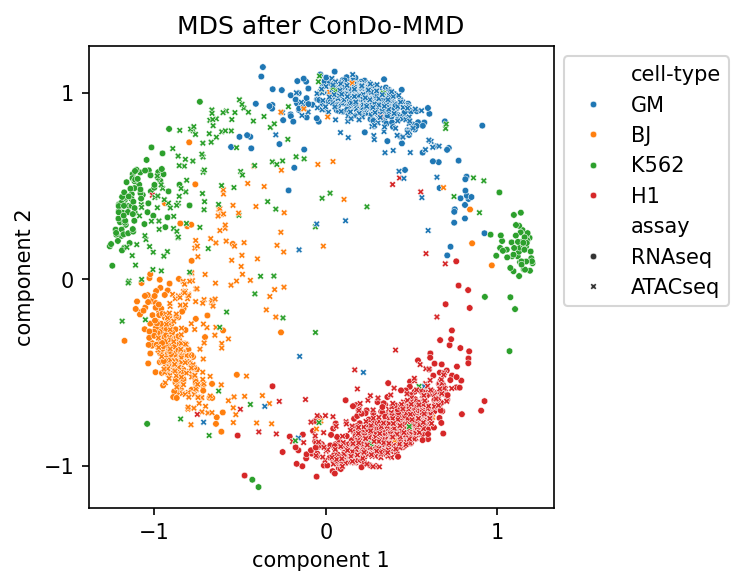

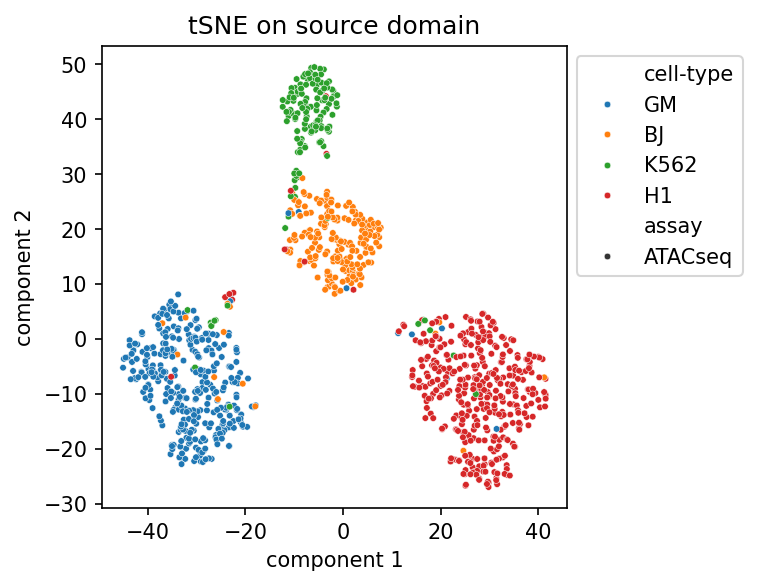

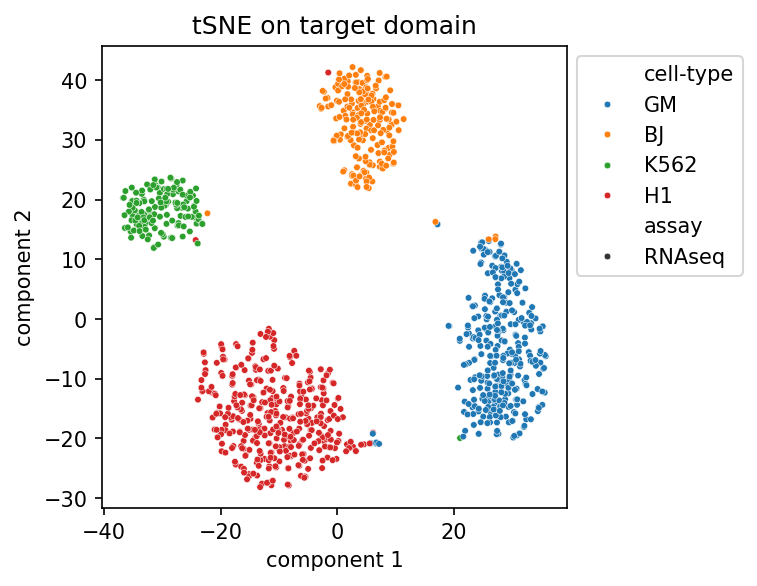

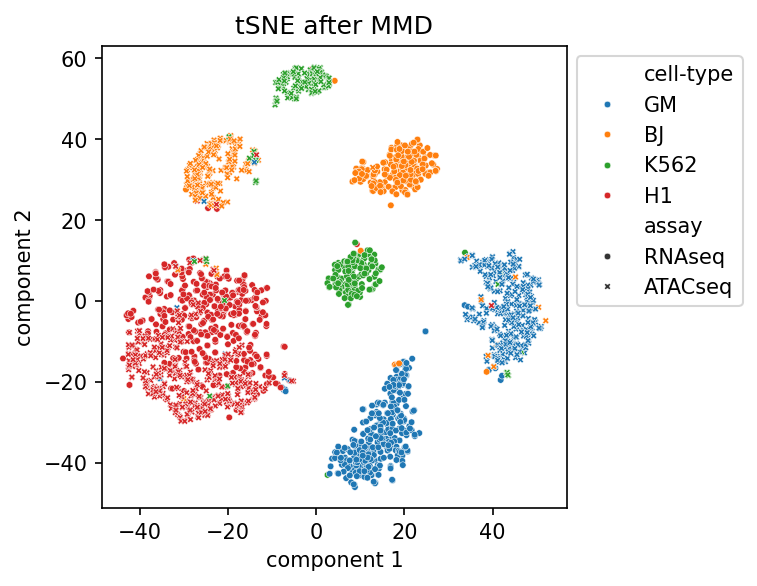

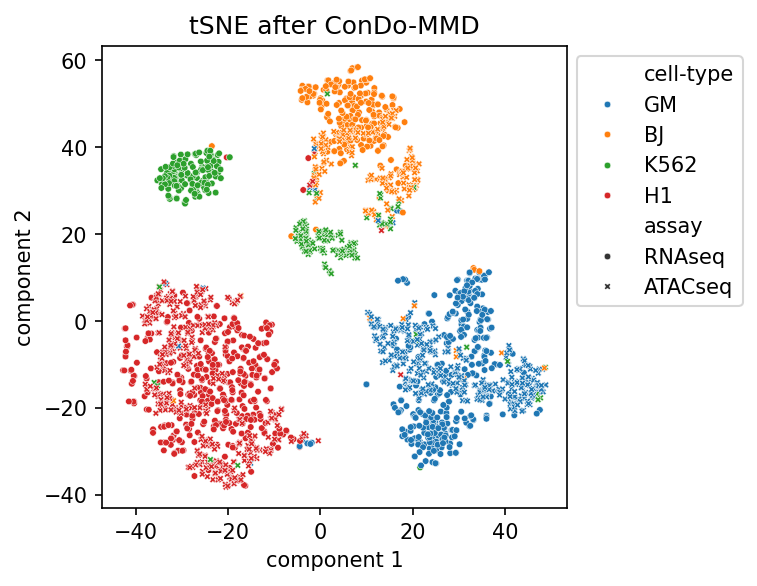

In [4]:
embeddings = [('PCA', PCA), ('MDS', MDS), ('tSNE', TSNE)]
for embname, emb in embeddings:
    em_s = emb(n_components=2).fit_transform(Xsn)
    em_s_df = pd.DataFrame(em_s, columns=['component 1', 'component 2'])
    em_s_df['cell'] = np.r_[Zs,]
    em_s_df['domain'] = np.r_[np.full(fill_value='source', shape=Zs.shape),]
    em_s_df['cell-type'] = em_s_df['cell'].apply(lambda elt: celldict[elt])
    em_s_df['assay'] = em_s_df['domain'].apply(lambda elt: {'target': 'RNAseq', 'source': 'ATACseq'}[elt])
    plt.figure(figsize=(4,4), dpi=150);
    g = sns.scatterplot(
        data=em_s_df, x='component 1', y='component 2', 
        hue='cell-type', style='assay', s=10); #hue_order=['1', '2', '3', '4']
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    if embname == 'MDS':
        plt.xticks([-1, 0, 1]);
        plt.yticks([-1, 0, 1]);   
    plt.title(f'{embname} on source domain');

    em_t = emb(n_components=2).fit_transform(Xtn)
    em_t_df = pd.DataFrame(em_t, columns=['component 1', 'component 2'])
    em_t_df['cell'] = np.r_[Zt,]
    em_t_df['domain'] = np.r_[np.full(fill_value='target', shape=Zt.shape),]
    em_t_df['cell-type'] = em_t_df['cell'].apply(lambda elt: celldict[elt])
    em_t_df['assay'] = em_t_df['domain'].apply(lambda elt: {'target': 'RNAseq', 'source': 'ATACseq'}[elt])
    plt.figure(figsize=(4,4), dpi=150);
    g = sns.scatterplot(
        data=em_t_df, x='component 1', y='component 2', 
        hue='cell-type', style='assay', s=10); #hue_order=['1', '2', '3', '4']
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    if embname == 'MDS':
        plt.xticks([-1, 0, 1]);
        plt.yticks([-1, 0, 1]);   
    plt.title(f'{embname} on target domain');

    em_mmd = emb(n_components=2).fit_transform(np.r_[Xtn, Xsn2tn_mmd])
    em_mmd_df = pd.DataFrame(em_mmd, columns=['component 1', 'component 2'])
    em_mmd_df['cell'] = np.r_[Zt, Zs]
    em_mmd_df['domain'] = np.r_[np.full(fill_value='target', shape=Zt.shape), np.full(fill_value='source', shape=Zs.shape)]
    em_mmd_df['cell-type'] = em_mmd_df['cell'].apply(lambda elt: celldict[elt])
    em_mmd_df['assay'] = em_mmd_df['domain'].apply(lambda elt: {'target': 'RNAseq', 'source': 'ATACseq'}[elt])
    plt.figure(figsize=(4,4), dpi=150);
    g = sns.scatterplot(
        data=em_mmd_df, x='component 1', y='component 2', 
        hue='cell-type', style='assay', s=10); #hue_order=['1', '2', '3', '4']
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    if embname == 'MDS':
        plt.xticks([-1, 0, 1]);
        plt.yticks([-1, 0, 1]);   
    plt.title(f'{embname} after MMD');
    
    em_cmmd = emb(n_components=2).fit_transform(np.r_[Xtn, Xsn2tn_cmmd])
    em_cmmd_df = pd.DataFrame(em_cmmd, columns=['component 1', 'component 2'])
    em_cmmd_df['cell'] = np.r_[Zt, Zs]
    em_cmmd_df['domain'] = np.r_[np.full(fill_value='target', shape=Zt.shape), np.full(fill_value='source', shape=Zs.shape)]
    em_cmmd_df['cell-type'] = em_cmmd_df['cell'].apply(lambda elt: celldict[elt])
    em_cmmd_df['assay'] = em_cmmd_df['domain'].apply(lambda elt: {'target': 'RNAseq', 'source': 'ATACseq'}[elt])
    plt.figure(figsize=(4,4), dpi=150);
    g = sns.scatterplot(
        data=em_cmmd_df, x='component 1', y='component 2', 
        hue='cell-type', style='assay', s=10); #hue_order=['1', '2', '3', '4']
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    if embname == 'MDS':
        plt.xticks([-1, 0, 1]);
        plt.yticks([-1, 0, 1]);
    plt.title(f'{embname} after ConDo-MMD');